In [1]:
using QuadGK
using Plots

In this notebook I will compare different projection methods.

1. Fourier Sine Projection
2. Jacobi Polynomials
3. Exponential Radial Basis Interpolation
4. Bump Function Radial Basis Interpolation

In [16]:
# Test Functions
F(x) = x^2
G(x) = √2 * sin(2π*x)

# Plotting Grid
npoints = 201
X = range(0, 1, length=npoints)

0.0:0.005:1.0

## Functionals

In [108]:
zeros_like([1, 2])

LoadError: UndefVarError: zeros_like not defined

In [3]:
# Start with creating functionals and utility functions
function pointwise_product(f, g)
    function (x)
        f(x) * g(x)
    end
end


function pointwise_difference(f, g)
    function (x)
        f(x) - g(x)
    end
end

function pointwise_square(f)
    function(x)
        f(x)^2
    end
end

# Create various l2-functionals
function l2_inner_product(f, g)
    prod = pointwise_product(f, g)
    return quadgk(prod, 0, 1)[1]
end


function l2_distance(f, g)
    diff_squared = pointwise_square(pointwise_difference(f, g))
    return sqrt(quadgk(diff_squared, 0, 1)[1])
end


function l2_norm(f)
    return sqrt(quadgk(f, 0, 1)[1])
end

l2_norm (generic function with 1 method)

## Projection Method 

In [4]:
"""Function Builder. Takes a vector of basis functions, and a set of weights,
and return a function taking the linear combinations of this at x."""
function build_function(weights, basis)
#     @assert length(weights) == length(basis), "weights and basis needs to be same length"
    n = length(weights)
    function (x)
        out = 0.0
        for i in 1:n
            out += weights[i] * basis[i](x)
        end
        return out
    end
end


"""Computes the orthogonal projection coefficients for a function f in the direction
of each of the functions in the basis"""
function find_projection_weights(f, basis)
    return [l2_inner_product(f, bi) for bi in basis]
end


"""Orthogonal projection of f onto span(basis) with respect to the L2-metric""" 
function project(f, basis)
    weights = find_projection_weights(f, basis)
    return build_function(weights, basis)
end

project

## Fourier Sine Series Projection 

In [5]:
"""Create a vector containing the fourier sine series with 
period up to N"""
function fourier_sine_basis(N)
    return [x -> sqrt(2) * sin(π*n*x) for n in 1:N]
end

fourier_sine_basis

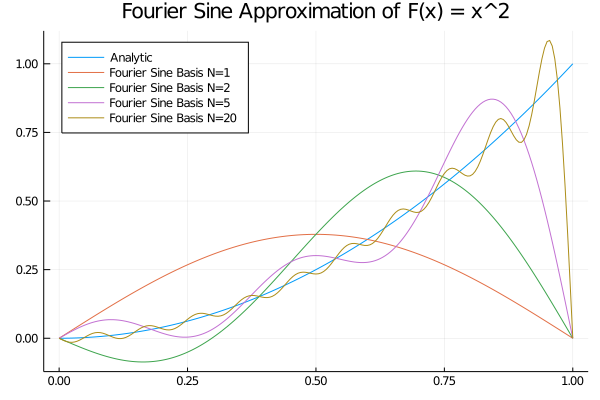

In [6]:
plot(F, X, label="Analytic", title="Fourier Sine Approximation of F(x) = x^2")
for n in [1, 2, 5, 20]
    f = project(F, fourier_sine_basis(n))
    plot!(f, X, label="Fourier Sine Basis N=$n", legend=:topleft)
end
display(plot!())

## Jacobi Polynomial Projection

In [7]:
using SpecialFunctions: gamma


""" Function to compute the normalizing constant of the n-th 
Jacobi-based polynomial"""

function C(n)
    return (2^5 / (2n+5))  * (gamma(n+3) * gamma(n+3)) / (32 * gamma(n+5) * factorial(big(n)))
end


""" Function to compute the coefficients of the n-th 
Jacobi-based polynomial"""
function B(n)
    return [gamma(n+3) * binomial(n, m) * gamma(n+m+5) / (factorial(big(n)) * gamma(n+5) * gamma(m+3)) for m in 0:n]
end


"""Construct the n-th jacobi-based polynomial. Note that 
the degree of the polynomial is 2 larger than n, n<2.
"""
function jacobi_polynomial(n)
    # Compute Coefficients in the jacobi polynomial
    Cn = C(n)
    Bn = [Float64(bi / sqrt(Cn)) for bi in B(n)]
    
    # Create function
    function (x)
        out = 0.0
        for m in 0:n
            out += Bn[m+1] * (x-1)^m
        end
        return out * x * (1-x)
    end
end


function jacobi_polynomial_basis(N)
    return [jacobi_polynomial(n) for n in 0:N-1]
end

jacobi_polynomial_basis (generic function with 1 method)

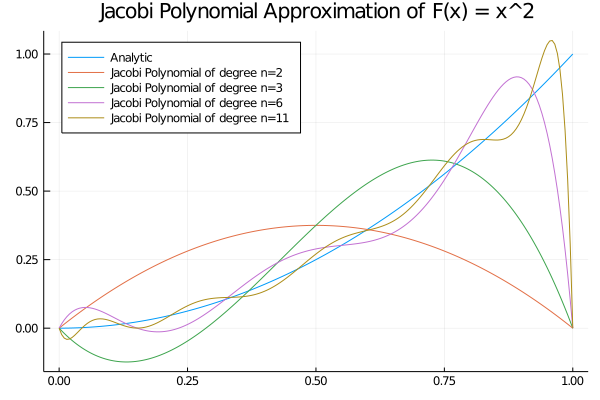

In [8]:
plot(F, X, label="Analytic", title="Jacobi Polynomial Approximation of F(x) = x^2")
for n in [1, 2, 5, 10]
    f = project(F, jacobi_polynomial_basis(n))
    plot!(f, X, label="Jacobi Polynomial of degree n=$(n+1)", legend=:topleft)
end
display(plot!())

## Interpolation by Radial Basis Functions

In [99]:
using LinearAlgebra: Symmetric

# First create a library of basis functions
function rbf_gaussian(center, ε)
    function (x)
        return exp(-ε*(x - center)^2)
    end
end

function rbf_multiquadratic(center, ε)
    function (x)
        return sqrt(1 + (ε*(x - center))^2)
    end
end

function rbf_inverse_multiquadratic(center, ε)
    function (x)
        return 1 / sqrt(1 + (ε*(x - center))^2)
    end
end

function rbf_inverse_quadratic(center, ε)
    function (x)
        return 1 / (1 + (ε*(x - center))^2)
    end
end

function rbf_bump_function(center, ε)
    function (x)
        if abs(x - center) < 1. / ε
            return exp(- 1. / (1 - (ε*(x - center))^2))
        end
        return 0.
    end
end

rbf_bump_function (generic function with 1 method)

### Visualize the Different Types of Radial Basis Functions|

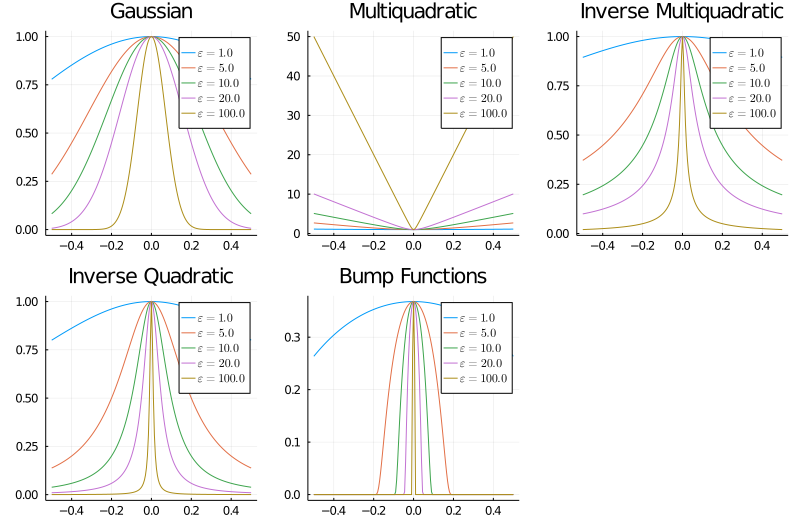

In [39]:
# Create function for visualizing different types of RBFs
function plot_rbf(rbf_type; title="")
    X_radial = -0.5:0.005:0.5
    p = plot(title=title)
    for ε in [1.0, 5., 10., 20., 100.]
        b = rbf_type(0, ε)
        plot!(b, X_radial, label="\$ \\varepsilon = $ε \$")
    end
    return p
end


# Create list of all functions to be plotted.
rbf_types = [rbf_gaussian, rbf_multiquadratic, rbf_inverse_multiquadratic, rbf_inverse_quadratic, rbf_bump_function]
rbf_titles = ["Gaussian", "Multiquadratic", "Inverse Multiquadratic", "Inverse Quadratic", "Bump Functions"]
rbf_plots = [plot_rbf(t, title=tit) for (t, tit) in zip(rbf_types, rbf_titles)]

plot(rbf_plots...,  layout=5, size=(800, 530))

In [100]:
function build_interpolation_matrix(nodes, basis)
    return [bi(xj) for xj in nodes, bi in basis]
end


function build_rbf_basis(nodes, ε::Number, rbf_type)
    return [rbf_type(xj, ε) for xj in nodes]
end


function build_rbf_basis(nodes, ε::Array, rbf_type)
    @assert length(nodes) == length(ε)
    return [rbf_type(nodes[i], ε[i]) for i in 1:length(nodes)]
end


function find_interpolation_weights(f, nodes, basis)
    F = [f(xi) for xi in nodes]
    F[1] = 0.
    F[end] = 0.
    
    A = build_interpolation_matrix(nodes, basis)
    
    return A \ F
end
        
function build_interpolation_vector()
    throw("build_interpolation_vector not implemeted")
end

build_interpolation_vector (generic function with 1 method)

In [41]:
### Should create a struct for building this.
function interpolate(f, nodes, basis)
    weights = find_interpolation_weights(f, nodes, basis)
    return build_function(weights, basis)
end

function interpolation_error(f, N; rbf=rbf_gaussian, param=1.0)
    nodes = range(0, 1, length=N)
    basis = build_rbf_basis(nodes, param, rbf)
    f_interp = interpolate(f, nodes, basis)
    return l2_distance(f, f_interp)
end    

interpolation_error (generic function with 1 method)

In [77]:
N÷2

7

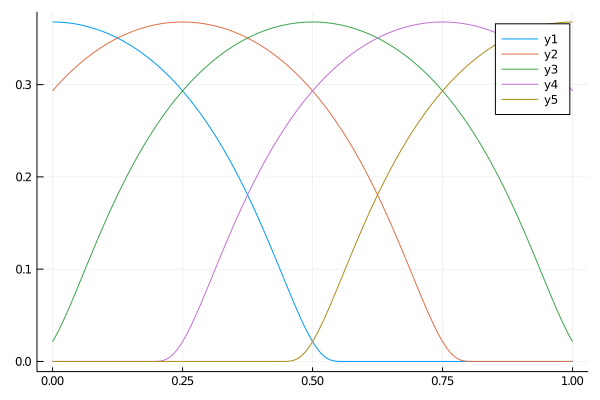

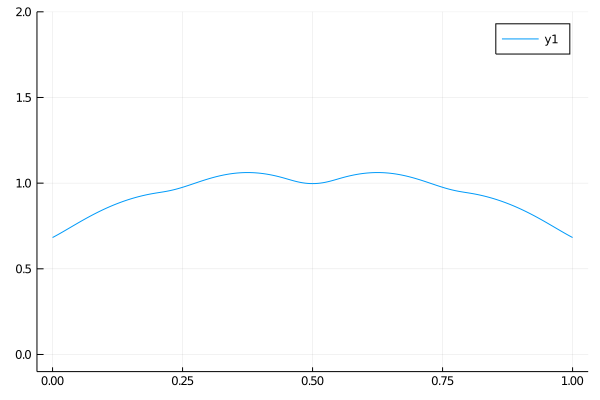

In [96]:
N = 5
nodes = range(0, 1, length=N)


param = (N-1) * 0.43#sqrt(log(2 / (ℯ-1)) / (1 + log(2/ (ℯ-1))))


basis = build_rbf_basis(nodes, param, rbf_bump_function)

plot()
for bi in basis
    plot!(bi, X)
end
display(plot!())
plot(x -> sum([bi(x) for bi in  basis]), X, ylims=(-0.1, 2.))

display(plot!())

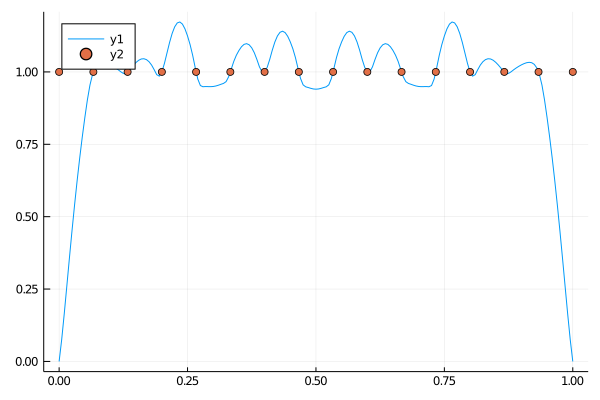

In [101]:
N = 16
test(x) = 1.

param =  ones(N) * (N - 1) * 0.43


nodes = range(0, 1, length=N)
basis = build_rbf_basis(nodes, param, rbf_bump_function)
weights = find_interpolation_weights(test, nodes, basis)
F_gaussian = build_function(weights, basis)

plot(F_gaussian, X, legend=:topleft)
scatter!(nodes, test.(nodes))

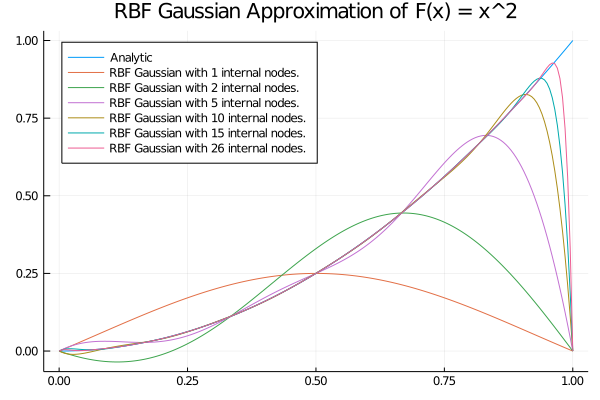

In [106]:
param = 100.

plot(F, X, label="Analytic", title="RBF Gaussian Approximation of F(x) = x^2")
for n in [1, 2, 5, 10, 15, 26]
    nodes = range(0, 1, length=n+2)
    param = (n + 1) * sqrt(log(2))
    f = interpolate(F, nodes, build_rbf_basis(nodes, param, rbf_gaussian))
    plot!(f, X, label="RBF Gaussian with $n internal nodes.", legend=:topleft)
#     scatter!(nodes, f.(nodes), label="")
end
display(plot!())

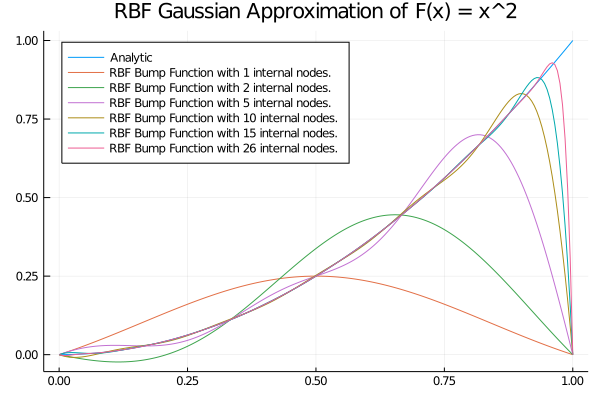

In [107]:
param = 100.

plot(F, X, label="Analytic", title="RBF Gaussian Approximation of F(x) = x^2")
for n in [1, 2, 5, 10, 15, 26]
    nodes = range(0, 1, length=n+2)
    param = 2 * (n + 1) * sqrt((log(4) -1 / log(4)))
    f = interpolate(F, nodes, build_rbf_basis(nodes, param, rbf_gaussian))
    plot!(f, X, label="RBF Bump Function with $n internal nodes.", legend=:topleft)
#     scatter!(nodes, f.(nodes), label="")
end
display(plot!())

In [ ]:
function interpolation_error(f, N; rbf=rbf_gaussian, param=1.0)
    nodes = range(0, 1, length=N)
    basis = build_rbf_basis(nodes, param, rbf)
    f_interp = interpolate(f, nodes, basis)
    return l2_distance(f, f_interp)
end
    

In [86]:
function parameter_error(ε; N=11)
    nodes = range(0, 1, length=N)
    basis = build_rbf_basis(nodes, ε, rbf_gaussian)
    f_interp = interpolate(F, nodes, basis)
    return l2_distance(F, f_interp)
end

LoadError: syntax: extra token ")" after end of expression

In [87]:
using Optim

In [83]:
x0 = 10. * ones(10)
optimize(parameter_error, -2.0, 1.0)
parameter_error(x0)

0.17540155880941277

In [85]:
optimize(parameter_error, x0, BFGS())

LoadError: DomainError with 0.5:
integrand produced NaN in the interval (0, 1)

In [111]:
using ForwardDiff
using LinearAlgebra